# Task -Project MalJPEG

## Imports

In [1]:
# Imports
import numpy as np # Support for large arrays and matrices, along with high-level mathematical functions.
import seaborn as sns # Graphing/Plotting module.
import pandas as pd # CSV handling with operations on tabular data.
import lightgbm as lgb

from ast import literal_eval
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder

from collections import Counter

In [2]:
def checkPredictions(lgb_p, dtc_p, rfc_p, xgb_p, labels):
    for idx, _ in enumerate(lgb_p):
        if lgb_p[idx]!= labels[idx] or dtc_p[idx]!= labels[idx] or rfc_p[idx]!= labels[idx] or xgb_p[idx]!= labels[idx]:
            print(lgb_p[idx], dtc_p[idx], rfc_p[idx], xgb_p[idx], labels[idx])

# Post ML
def count_voles(votes):
    # count the votes for type
    vote_count=Counter(votes)
 
    # find the maximum number of votes
    max_votes = max(vote_count.values())
 
    # search for type having maximum votes and store in a list
    lst=[i for i in vote_count.keys() if vote_count[i]==max_votes]
 
    # sort the list
    return max_votes, sorted(lst)[0]

def final_predictions(dtc_p, rfc_p, xgb_p):
    final_result = []
    for idx, _ in enumerate(dtc_p):
        if dtc_p[idx] != rfc_p[idx] or dtc_p[idx] != xgb_p[idx] or rfc_p[idx] != xgb_p[idx]:
            max_votes, chosen = count_voles([dtc_p[idx], rfc_p[idx], xgb_p[idx]])
            if max_votes == 1:
                final_result.append(xgb_p[idx])
            else:
                final_result.append(chosen)
        else:
            final_result.append(dtc_p[idx])
    return final_result

## Read Data and Preprocess it to fit into DeepMAL model

In [3]:
# Read Data
dataset_type_1 = 'markers_image_my.csv' # other options: 'markers_image.csv' or 'metadata.csv'

filepath = f'./datasets/{dataset_type_1}'
df_1 = pd.read_csv(filepath)

dataset_type_2 = 'metadata.csv' # other options: 'markers_image.csv' or 'metadata.csv'

filepath = f'./datasets/{dataset_type_2}'
df_2 = pd.read_csv(filepath)
label_encoder = LabelEncoder()
df_2['Make'] = label_encoder.fit_transform(df_2['Make'])
df = df_1.merge(df_2, on='filename', how='left')

## Preprocess the data

In [4]:
label_type = 'label_x' # options: 'label'

X = np.stack([
    # MalJPEG
    df['Marker_EOI_content_after_num'], df['File_markers_num'], df['File_size'],
    df['Marker_APP1_size_max'], df['Marker_APP12_size_max'], df['Marker_COM_size_max'], 
    df['Marker_DHT_num'], df['Marker_DHT_size_max'], df['Marker_DQT_num'], 
    df['Marker_DQT_size_max'],
    # My features
    df['Marker_APP_other_size_max'], df['Marker_APP_other_num'], 
    df['Marker_SOF_size_max'], df['Marker_DRI_num'], df['Marker_RST_num'],
    df['Marker_SOS_len'], df['Marker_EOI'],
    # My features from metadata
    df['ExifInteroperabilityOffset'], df['SceneCaptureType'],  df['MeteringMode'], 
    df['LightSource'], df['Flash'], df['ColorSpace'],  
    df['Make'], df['ExposureProgram'], df['ResolutionUnit'], df['Exception_num'],
]).T

y = np.stack(df[label_type])

scaler_mix = StandardScaler()
scaler_mix.fit(X)
X = scaler_mix.transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1666, stratify=y)

## Train/Fit

In [6]:
# LGBM classifier
lgb_clf = lgb.LGBMClassifier(n_estimators=500, n_jobs=4, random_state=2021,
                             boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                             importance_type='split', learning_rate=0.1, max_depth=-1,
                             min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                             num_leaves=31, objective=None, reg_alpha=0.0, reg_lambda=0.0,
                             subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
lgb_clf.fit(X_train, y_train)

LGBMClassifier(n_estimators=500, n_jobs=4, random_state=2021)

In [7]:
# Decision Tree classifier
dtc_clf = DecisionTreeClassifier(max_depth=30, random_state=1914)
dtc_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=30, random_state=1914)

In [8]:
# Random Forest classifier
rfc_clf = RandomForestClassifier(n_estimators=500, max_depth=30, n_jobs=4, random_state=2021)
rfc_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=500, n_jobs=4,
                       random_state=2021)

In [9]:
# XGB classifier
xgb_clf = XGBClassifier(n_estimators=500, max_depth=30, n_jobs=4, eval_metric='mlogloss', 
                        random_state=1941, use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=30, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=1941,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

## Test/Predict

In [10]:
lgb_predictions = lgb_clf.predict(X_test)
dtc_predictions = dtc_clf.predict(X_test)
rfc_predictions = rfc_clf.predict(X_test)
xgb_predictions = xgb_clf.predict(X_test)
    
true_labels = y_test

accuracy score: 99.91%
TPR: 0.993
FPR: 0.000
AUC&ROC 0.9960663280649131
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8209
           1       0.99      0.99      0.99       542

    accuracy                           1.00      8751
   macro avg       1.00      1.00      1.00      8751
weighted avg       1.00      1.00      1.00      8751



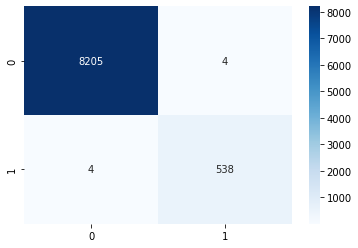

In [11]:
cf_matrix = confusion_matrix(true_labels, lgb_predictions)

accuracy = accuracy_score(true_labels, lgb_predictions)
print("accuracy score: {0:.2f}%".format(accuracy*100))
print("TPR: {0:.3f}".format(cf_matrix[1][1]/(cf_matrix[0][1]+cf_matrix[1][1])))
print("FPR: {0:.3f}".format(cf_matrix[0][1]/(cf_matrix[0][0]+cf_matrix[1][0])))
print("AUC&ROC", roc_auc_score(true_labels, lgb_predictions))
print(classification_report(true_labels, lgb_predictions))

heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels))

accuracy score: 99.90%
TPR: 0.991
FPR: 0.001
AUC&ROC 0.9960054193062335
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8209
           1       0.99      0.99      0.99       542

    accuracy                           1.00      8751
   macro avg       1.00      1.00      1.00      8751
weighted avg       1.00      1.00      1.00      8751



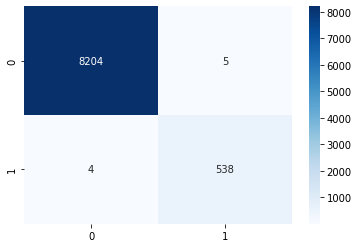

In [12]:
cf_matrix = confusion_matrix(true_labels, dtc_predictions)

accuracy = accuracy_score(true_labels, dtc_predictions)
print("accuracy score: {0:.2f}%".format(accuracy*100))
print("TPR: {0:.3f}".format(cf_matrix[1][1]/(cf_matrix[0][1]+cf_matrix[1][1])))
print("FPR: {0:.3f}".format(cf_matrix[0][1]/(cf_matrix[0][0]+cf_matrix[1][0])))
print("AUC&ROC", roc_auc_score(true_labels, dtc_predictions))
print(classification_report(true_labels, dtc_predictions))

heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels))

accuracy score: 99.91%
TPR: 0.993
FPR: 0.000
AUC&ROC 0.9960663280649131
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8209
           1       0.99      0.99      0.99       542

    accuracy                           1.00      8751
   macro avg       1.00      1.00      1.00      8751
weighted avg       1.00      1.00      1.00      8751



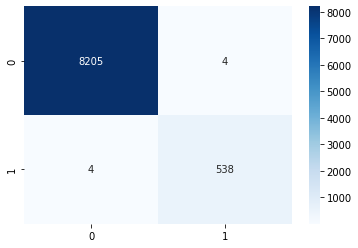

In [13]:
cf_matrix = confusion_matrix(true_labels, rfc_predictions)

accuracy = accuracy_score(true_labels, rfc_predictions)
print("accuracy score: {0:.2f}%".format(accuracy*100))
print("TPR: {0:.3f}".format(cf_matrix[1][1]/(cf_matrix[0][1]+cf_matrix[1][1])))
print("FPR: {0:.3f}".format(cf_matrix[0][1]/(cf_matrix[0][0]+cf_matrix[1][0])))
print("AUC&ROC", roc_auc_score(true_labels, rfc_predictions))
print(classification_report(true_labels, rfc_predictions))

heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels))

accuracy score: 99.91%
TPR: 0.993
FPR: 0.000
AUC&ROC 0.9960663280649131
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8209
           1       0.99      0.99      0.99       542

    accuracy                           1.00      8751
   macro avg       1.00      1.00      1.00      8751
weighted avg       1.00      1.00      1.00      8751



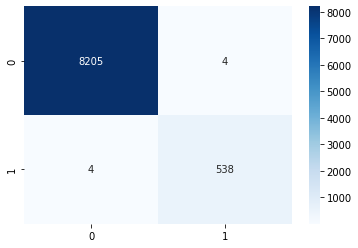

In [14]:
cf_matrix = confusion_matrix(true_labels, xgb_predictions)

accuracy = accuracy_score(true_labels, xgb_predictions)
print("accuracy score: {0:.2f}%".format(accuracy*100))
print("TPR: {0:.3f}".format(cf_matrix[1][1]/(cf_matrix[0][1]+cf_matrix[1][1])))
print("FPR: {0:.3f}".format(cf_matrix[0][1]/(cf_matrix[0][0]+cf_matrix[1][0])))
print("AUC&ROC", roc_auc_score(true_labels, xgb_predictions))
print(classification_report(true_labels, xgb_predictions))

heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels))

In [15]:
print(lgb_clf.feature_importances_)

[803 344 824 611  81 126  37 541  30  47 287  57   4  21  19 912 132  81
   5 108  24  35  96 289  11  65  40]


In [16]:
print(dtc_clf.feature_importances_)

[6.45801090e-01 5.83006208e-04 1.57595415e-03 2.33279180e-03
 9.89209554e-06 1.12824476e-04 0.00000000e+00 7.76286107e-05
 0.00000000e+00 0.00000000e+00 2.60023334e-03 6.75177062e-04
 4.21985664e-04 0.00000000e+00 0.00000000e+00 3.05480511e-03
 7.05030977e-02 2.89753571e-04 0.00000000e+00 1.04924059e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.71856837e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [17]:
print(rfc_clf.feature_importances_)

[0.51622872 0.01754089 0.04632481 0.03451775 0.00273702 0.01210689
 0.01466056 0.03254297 0.00799424 0.01140152 0.00846829 0.00596997
 0.01173378 0.00062663 0.00234591 0.04087789 0.01911353 0.00308637
 0.00084274 0.00192944 0.00110701 0.002327   0.00989787 0.18654423
 0.0012148  0.00630189 0.00155728]


In [18]:
print(xgb_clf.feature_importances_)

[3.2902375e-01 1.7885414e-03 6.6879793e-04 1.5842824e-03 2.5027958e-03
 2.7741434e-03 1.6197453e-04 1.1862301e-02 2.2787780e-04 5.6780413e-05
 1.7296857e-03 4.1974100e-04 0.0000000e+00 7.0187347e-03 4.4496954e-04
 1.1030983e-03 3.6765403e-01 2.9183323e-03 9.0786692e-04 1.5106472e-03
 5.6160470e-03 1.5956545e-03 1.8653808e-02 2.1928422e-01 9.3831646e-04
 1.9184014e-02 3.6956405e-04]


accuracy score: 99.91%
TPR: 0.993
FPR: 0.000
AUC&ROC 0.9960663280649131
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8209
           1       0.99      0.99      0.99       542

    accuracy                           1.00      8751
   macro avg       1.00      1.00      1.00      8751
weighted avg       1.00      1.00      1.00      8751



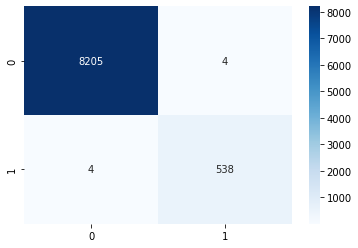

In [19]:
predictions = final_predictions(xgb_predictions, lgb_predictions, rfc_predictions)
cf_matrix = confusion_matrix(true_labels, predictions)

accuracy = accuracy_score(true_labels, predictions)
print("accuracy score: {0:.2f}%".format(accuracy*100))
print("TPR: {0:.3f}".format(cf_matrix[1][1]/(cf_matrix[0][1]+cf_matrix[1][1])))
print("FPR: {0:.3f}".format(cf_matrix[0][1]/(cf_matrix[0][0]+cf_matrix[1][0])))
print("AUC&ROC", roc_auc_score(true_labels, predictions))
print(classification_report(true_labels, predictions))

heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels))

In [20]:
checkPredictions(lgb_predictions, dtc_predictions, rfc_predictions, xgb_predictions, true_labels)

1 0 0 0 0
1 1 1 1 0
1 1 1 1 0
1 1 1 1 0
0 0 0 0 1
0 0 0 0 1
0 1 1 1 0
0 0 0 0 1
0 1 0 0 0
0 0 0 0 1
